# 4-qubit 1D XY-model

In [121]:
import pennylane as qml
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import numpy as np
from numpy import array
import scipy
from scipy.optimize import minimize
import networkx as nx
import itertools
from numpy import savetxt
from numba import jit, cuda
import seaborn

np.random.seed(42)

## 1. Hamiltonian

### $$H=\sum_{<i,j>} (X_{i}X_{j}+Y_{i}Y_{j})+h\sum_{i}Z_{i}$$

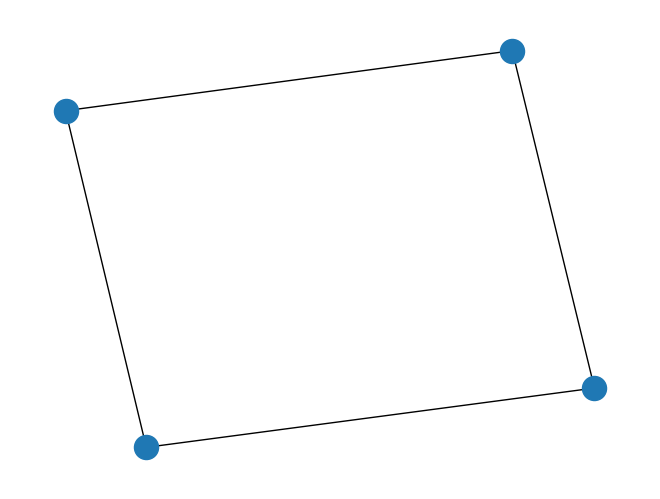

In [619]:
# Interaction Picture

interaction_graph = nx.cycle_graph(nr_qubits)
nx.draw(interaction_graph)

In [622]:
interaction_graph.edges

EdgeView([(0, 1), (0, 3), (1, 2), (2, 3)])

In [623]:
# Initial Variables

nr_qubits = 4
h=-1

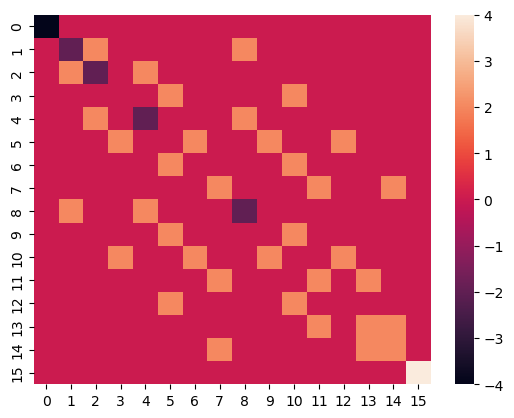

In [626]:
# Hamiltonian
def create_hamiltonian_matrix(n, h, graph):
    matrix = np.zeros((2 ** n, 2 ** n))
    for i in graph.edges:
        x = y = 1
        for j in range(0, n):
            if j == i[0]:
                x = np.kron(x, qml.matrix(qml.PauliX)(0))
                y = np.kron(y, qml.matrix(qml.PauliY)(0))
                
            elif j == i[1]:
                x = np.kron(x, qml.matrix(qml.PauliX)(0))
                y = np.kron(y, qml.matrix(qml.PauliY)(0))
                
            else:
                x = np.kron(x, np.identity(2))
                y = np.kron(y, np.identity(2))
            
        matrix = np.add(matrix, np.add(x, y))

    for i in range(0, n):
        z = 1
        for j in range(0, n):
            if j == i:
                z = np.kron(z, qml.matrix(qml.PauliZ)(0))           
                
            else:
                z = np.kron(z, np.identity(2))
                
        matrix = np.add(matrix, h*z) 
        
    return matrix


ham_matrix=create_hamiltonian_matrix(nr_qubits, h, interaction_graph)

# Prints a visual representation of the Hamiltonian matrix
seaborn.heatmap(ham_matrix.real)
plt.show()

## 2. Ansatz Circuit

In [627]:
# Initial Variables

depth = 4
dev = qml.device("default.qubit", wires=nr_qubits)

Ansatz is composed of rotation layer and coupling layer. "quantum_circuit" function randomly creates ansatz. In this function, each layer is repeated as much as depth.

In [628]:
# Ansatz Preparation

# Rotation Layer Function
def single_rotation(phi_params, qubits):

    rotations = ["Z", "Y", "X"]
    for i in range(0, len(rotations)):
        qml.AngleEmbedding(phi_params[i], wires=qubits, rotation=rotations[i])

# Ansatz Preparation Function
@qml.qnode(dev)
def quantum_circuit(rotation_params, coupling_params, sample=None):

    # Prepares the initial basis state corresponding to the sample
    qml.BasisStatePreparation(sample, wires=range(nr_qubits))

    # Prepares the variational ansatz for the circuit
    for i in range(0, depth):
        # Rotation Layer
        single_rotation(rotation_params[i], range(nr_qubits))

        # Coupling Layer
        qml.broadcast(unitary=qml.CRX, pattern="ring", wires=range(nr_qubits), parameters=coupling_params[i])

    # Calculates the expectation value of the Hamiltonian with respect to the prepared states
    return qml.expval(qml.Hermitian(ham_matrix, wires=range(nr_qubits)))

In [629]:
# Utilty Functions

# Sigmoid Function
def sigmoid(x):
    return np.exp(x) / (np.exp(x) + 1)

# Probability Distribution Function
def prob_dist(params):
    return np.vstack([sigmoid(params), 1 - sigmoid(params)]).T

# Conversion Function
def convert_list(params):

    # Separates the list of parameters
    dist_params = params[0:nr_qubits]
    ansatz_params_1 = params[nr_qubits : ((depth + 1) * nr_qubits)]
    ansatz_params_2 = params[((depth + 1) * nr_qubits) :]

    coupling = np.split(ansatz_params_1, depth)

    # Partitions the parameters into multiple lists
    split = np.split(ansatz_params_2, depth)
    rotation = []
    for s in split:
        rotation.append(np.split(s, 3))

    ansatz_params = [rotation, coupling]

    return [dist_params, ansatz_params]

## 3. Cost Function

In [630]:
# Neumann Entropy
def calculate_entropy(distribution):

    total_entropy = 0
    for d in distribution:
        total_entropy += -1 * d[0] * np.log(d[0]) + -1 * d[1] * np.log(d[1])

    # Returns an array of the entropy values of the different initial density matrices

    return total_entropy

# Energy Function
def energy(params,beta):

    global iterations

    # Transforms the parameter list
    parameters = convert_list(params)
    dist_params = parameters[0]
    ansatz_params = parameters[1]

    # Creates the probability distribution
    distribution = prob_dist(dist_params)

    # Generates a list of all computational basis states of our qubit system
    combos = itertools.product([0, 1], repeat=nr_qubits)
    s = [list(c) for c in combos]

    # Passes each basis state through the variational circuit and multiplies
    # the calculated energy EV with the associated probability from the distribution
    cost = 0
    for i in s:
        result = qnode(ansatz_params[0], ansatz_params[1], sample=i)
        for j in range(0, len(i)):
            result = result * distribution[j][i[j]]
        cost += result

    final_cost = cost

    return final_cost

# Cost Function
@jit(target_backend='cuda')      
def exact_cost(params,beta):

    global iterations

    # Transforms the parameter list
    parameters = convert_list(params)
    dist_params = parameters[0]
    ansatz_params = parameters[1]

    # Creates the probability distribution
    distribution = prob_dist(dist_params)

    # Generates a list of all computational basis states of our qubit system
    combos = itertools.product([0, 1], repeat=nr_qubits)
    s = [list(c) for c in combos]

    # Passes each basis state through the variational circuit and multiplies
    # the calculated energy EV with the associated probability from the distribution
    cost = 0
    for i in s:
        result = quantum_circuit(ansatz_params[0], ansatz_params[1], sample=i)
        for j in range(0, len(i)):
            result *= distribution[j][i[j]]
        cost += result
       

    # Calculates the entropy and the final cost function
    entropy = calculate_entropy(distribution)
    final_cost = beta * cost - entropy

    return final_cost, cost

## 4. VQT

In [631]:
# M_matrix
M_matrix = 1
for i in range(nr_qubits):
    if i==0 :
        M_matrix = np.kron(M_matrix, qml.matrix(qml.PauliZ(0)))
    else :
        M_matrix = np.kron(M_matrix, np.identity(2)) 

In [ ]:
M_matrix = np.zeros((2 ** nr_qubits, 2 ** nr_qubits))
x = y = 1
for j in range(0, nr_qubits):
    if j == 0:
        x = np.kron(x, qml.matrix(qml.PauliX)(0))
        y = np.kron(y, qml.matrix(qml.PauliY)(0))
                
    elif j == 1:
        x = np.kron(x, qml.matrix(qml.PauliX)(0))
        y = np.kron(y, qml.matrix(qml.PauliY)(0))
                
    else:
        x = np.kron(x, np.identity(2))
        y = np.kron(y, np.identity(2))
        
M_matrix=np.add(x, y)

In [105]:
# Auxiliary Function
def cost_execution(params,beta):

    global iterations

    cost, _ = exact_cost(params,beta)
   
    cost_list.append(cost)
    if iterations % 50 == 0:
        print("Cost at Step {}: {}".format(iterations, cost))

    iterations += 1
    return cost

# Initial State Preparation Function
def prepare_state(params, device):

    # Initializes the density matrix

    final_density_matrix = np.zeros((2 ** nr_qubits, 2 ** nr_qubits))

    # Prepares the optimal parameters, creates the distribution and the bitstrings
    parameters = convert_list(params)
    dist_params = parameters[0]
    unitary_params = parameters[1]

    distribution = prob_dist(dist_params)

    combos = itertools.product([0, 1], repeat=nr_qubits)
    s = [list(c) for c in combos]

    # Runs the circuit in the case of the optimal parameters, for each bitstring,
    # and adds the result to the final density matrix

    for i in s:
        quantum_circuit(unitary_params[0], unitary_params[1], sample=i)
        state = device.state
        for j in range(0, len(i)):
            state = np.sqrt(distribution[j][i[j]]) * state
        final_density_matrix = np.add(final_density_matrix, np.outer(state, np.conj(state)))

    return final_density_matrix

In [621]:
#Execution

E = []
C = []
M = []
T1 = [round(1*(10-i)/10, 2) for i in range(10)]+[round(10*(10-i)/10, 2) for i in range(10)]
beta_list=[]
for i in T1 :
    beta_list.append(1/i)

for beta in beta_list:
    print(f'Starting beta={beta} training')
    iterations = 0
    cost_list = []

    number = nr_qubits * (1 + depth * 4)
    params = [np.random.randint(-300, 300) / 100 for i in range(0, number)]
    params=np.array(params)
    out = minimize(cost_execution, x0=params, args=(beta),method="COBYLA", options={"maxiter": 1600})
    out_params = out["x"]
    prep_density_matrix = prepare_state(out_params, dev)
    savetxt(f'beta_is_{beta}.csv', cost_list, delimiter=',')
    savetxt(f'beta_is_{beta}_params.csv', out_params, delimiter=',')
    params = np.array(np.loadtxt(f'beta_is_{beta}_params.csv', dtype=float))
    cost, energy = exact_cost(params, beta)
    magnetization = np.trace(np.matmul(M_matrix, prep_density_matrix))
    print(f'E={energy}')
    print(f'M={magnetization}')
    E.append(energy)  
    M.append(magnetization)

Starting beta=1.0 training
Cost at Step 0: -4.146691157183245
Cost at Step 50: -6.224827428920553
Cost at Step 100: -10.852147203566
Cost at Step 150: -10.757729715149328
Cost at Step 200: -12.306780249810002
Cost at Step 250: -12.68955979122661
Cost at Step 300: -15.033292530981548
Cost at Step 350: -15.862949406573069
Cost at Step 400: -16.227426488208057
Cost at Step 450: -16.85494466957671
Cost at Step 500: -17.37096928775161
Cost at Step 550: -17.55575767470619
Cost at Step 600: -18.001099629488337
Cost at Step 650: -18.384146524850035
Cost at Step 700: -18.48645944888937
Cost at Step 750: -18.586427644881148
Cost at Step 800: -18.788765631043702
Cost at Step 850: -18.893690444706888
Cost at Step 900: -19.066636954696364
Cost at Step 950: -19.224087687920242
Cost at Step 1000: -19.31358543059524
Cost at Step 1050: -19.443146087479775
Cost at Step 1100: -19.502487758521934
Cost at Step 1150: -19.51004714324213
Cost at Step 1200: -19.564805778921667
Cost at Step 1250: -19.7029552002

Cost at Step 550: -46.563592865038515
Cost at Step 600: -46.87106724739191
Cost at Step 650: -47.666765235494466
Cost at Step 700: -48.09847167470679
Cost at Step 750: -48.37572579873258
Cost at Step 800: -48.53602433437658
Cost at Step 850: -48.701995936569986
Cost at Step 900: -48.77117321247597
Cost at Step 950: -48.92091064034833
Cost at Step 1000: -49.061417078981904
Cost at Step 1050: -49.249698159814585
Cost at Step 1100: -49.269283243166974
Cost at Step 1150: -49.361606411195275
Cost at Step 1200: -49.53850487824412
Cost at Step 1250: -49.59863777773358
Cost at Step 1300: -49.6671353143552
Cost at Step 1350: -49.777989094898025
Cost at Step 1400: -49.84485627795766
Cost at Step 1450: -49.90790280742047
Cost at Step 1500: -49.96137040275789
Cost at Step 1550: -50.009752668491636
E=-19.752543687852675
M=(-0.9724540342673296+0j)
Starting beta=3.3333333333333335 training
Cost at Step 0: -2.1237169367553235
Cost at Step 50: -19.138397362921836
Cost at Step 100: -31.947310542090772
C

Cost at Step 1200: -3.642701161525014
Cost at Step 1250: -3.6492707413125665
Cost at Step 1300: -3.65386708987136
Cost at Step 1350: -3.659471667907164
Cost at Step 1400: -3.6661424442415265
Cost at Step 1450: -3.6713715321885516
Cost at Step 1500: -3.6733910185734526
Cost at Step 1550: -3.679465049505522
E=-13.434938870134328
M=(-0.8686790886698758+0j)
Starting beta=0.14285714285714285 training
Cost at Step 0: -1.246105042318081
Cost at Step 50: -2.111934741111043
Cost at Step 100: -2.5648309432775873
Cost at Step 150: -2.810674913343156
Cost at Step 200: -3.052670001355228
Cost at Step 250: -3.1439873151023505
Cost at Step 300: -3.2138848609077995
Cost at Step 350: -3.3199811046022987
Cost at Step 400: -3.3685961735697516
Cost at Step 450: -3.4649434422216405
Cost at Step 500: -3.5831027818032912
Cost at Step 550: -3.604401344868515
Cost at Step 600: -3.684797844441667
Cost at Step 650: -3.784599688004625
Cost at Step 700: -3.855333259965129
Cost at Step 750: -3.9055741391082726
Cost

Cost at Step 150: -11.787447814754536
Cost at Step 200: -12.358406846169531
Cost at Step 250: -13.42212974666273
Cost at Step 300: -14.136107065357958
Cost at Step 350: -14.851569650095207
Cost at Step 400: -16.552350174268053
Cost at Step 450: -17.588683892359214
Cost at Step 500: -18.063177583937353
Cost at Step 550: -18.688140586782794
Cost at Step 600: -18.97186674442827
Cost at Step 650: -19.060887523371754
Cost at Step 700: -19.289129712034786
Cost at Step 750: -19.39115304039198
Cost at Step 800: -19.563672706557824
Cost at Step 850: -19.60118499109233
Cost at Step 900: -19.675497848501966
Cost at Step 950: -19.72837420744719
Cost at Step 1000: -19.82013361262896
Cost at Step 1050: -19.908097709209414
Cost at Step 1100: -19.960717936733992
Cost at Step 1150: -20.010817394888527
Cost at Step 1200: -20.02818290425434
Cost at Step 1250: -20.081876559165526
Cost at Step 1300: -20.10503656984277
Cost at Step 1350: -20.163952942866544
Cost at Step 1400: -20.196260145588777
Cost at Ste

In [467]:
E10
M10

[(-0.9796826144277044+0j),
 (-0.9558495045197343+0j),
 (-0.9644134993873938+0j),
 (-0.9541984084335189+0j),
 (-0.9662597292909415+0j),
 (-0.9615220601947452+0j),
 (-0.9509127259916659+0j),
 (-0.975472342933399+0j),
 (-0.9814110954202216+0j),
 (-0.9643112628580371+0j),
 (-0.8769228547653393+0j),
 (-0.9185116093903433+0j),
 (-0.9527360944698547+0j),
 (-0.9269294857605288+0j),
 (-0.9468554842553147+0j),
 (-0.967828123709143+0j),
 (-0.96723555493335+0j),
 (-0.9588580664301752+0j),
 (-0.9575703840830373+0j),
 (-0.9331443006782852+0j)]

In [498]:
E1
M1

[(0.756004467382791+0j),
 (0.4495265792539718+0j),
 (0.6460441596315819+0j),
 (0.6999604643300736+0j),
 (0.5438181577957122+0j),
 (0.6439919765325746+0j),
 (0.7284920539285105+0j),
 (0.6537761800193616+0j),
 (0.6014368092346947+0j),
 (0.6634317403434399+0j),
 (0.1527151915364262+0j),
 (0.2296591469683761+0j),
 (0.24711078701524297+0j),
 (0.14725673624211666+0j),
 (0.20015140779917684+0j),
 (0.37126831657681225+0j),
 (0.4479955102731943+0j),
 (0.562193120954494+0j),
 (0.6797415373985326+0j),
 (0.610238045501281+0j)]

## 5. Numerical Calculation

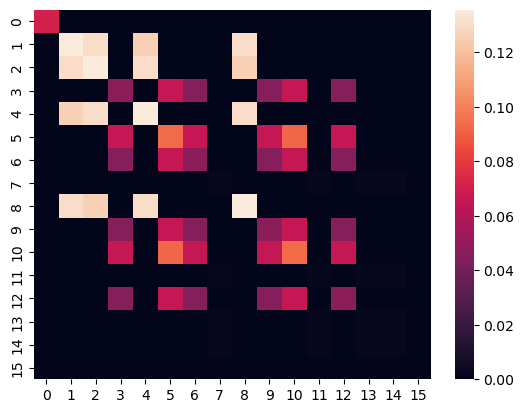

In [632]:
# Matrix Representation of the Thermal State
def create_target(qubit, beta, ham, b, graph):

    # Calculates the matrix form of the density matrix by taking the exponential of the Hamiltonian

    h = ham(qubit, b, graph)
    y = -1 * float(beta) * h
    new_matrix = scipy.linalg.expm(np.array(y))
    norm = np.trace(new_matrix)
    final_target = (1 / norm) * new_matrix

    return final_target

target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)

# Prints a visual representation of the demsity matrix
seaborn.heatmap(abs(target_density_matrix))
plt.show()

### Exact Calculation

#### h=-30

In [633]:
h=-30
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list30_ = []
magnetization_list30_=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list30_.append(exactenergy)
    magnetization_list30_.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in multiply
  final_target = (1 / norm) * new_matrix
C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  final_target = (1 / norm) * new_matrix


#### h=-25

In [634]:
h=-25
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list25_ = []
magnetization_list25_=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list25_.append(exactenergy)
    magnetization_list25_.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in multiply
  final_target = (1 / norm) * new_matrix
C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  final_target = (1 / norm) * new_matrix


#### h=-20

In [635]:
h=-20
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list20_ = []
magnetization_list20_=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list20_.append(exactenergy)
    magnetization_list20_.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in multiply
  final_target = (1 / norm) * new_matrix
C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  final_target = (1 / norm) * new_matrix


#### h=-18

In [636]:
h=-18
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list18_ = []
magnetization_list18_=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list18_.append(exactenergy)
    magnetization_list18_.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  final_target = (1 / norm) * new_matrix


#### h=-15

In [637]:
h=-15
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list15_ = []
magnetization_list15_=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list15_.append(exactenergy)
    magnetization_list15_.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  final_target = (1 / norm) * new_matrix


#### h=-12

In [638]:
h=-12
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list12_ = []
magnetization_list12_=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list12_.append(exactenergy)
    magnetization_list12_.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  final_target = (1 / norm) * new_matrix


#### h=-10

In [639]:
h=-10
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list10_ = []
magnetization_list10_=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list10_.append(exactenergy)
    magnetization_list10_.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  final_target = (1 / norm) * new_matrix


#### h=-8

In [640]:
h=-8
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list8_ = []
magnetization_list8_=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list8_.append(exactenergy)
    magnetization_list8_.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  final_target = (1 / norm) * new_matrix


#### h=-6

In [641]:
h=-6
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list6_ = []
magnetization_list6_=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list6_.append(exactenergy)
    magnetization_list6_.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  final_target = (1 / norm) * new_matrix


#### h=-4

In [642]:
h=-4
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list4_ = []
magnetization_list4_=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list4_.append(exactenergy)
    magnetization_list4_.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  final_target = (1 / norm) * new_matrix


#### h=-3

In [643]:
h=-3
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list3_ = []
magnetization_list3_=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list3_.append(exactenergy)
    magnetization_list3_.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in multiply
  final_target = (1 / norm) * new_matrix


#### h=-2

In [644]:
h=-2
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list2_ = []
magnetization_list2_=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list2_.append(exactenergy)
    magnetization_list2_.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in multiply
  final_target = (1 / norm) * new_matrix


#### h=-1.9

In [645]:
h=-1.9
beta_list = [1/t for t in np.linspace(0.01,100,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list1_9_ = []
magnetization_list1_9_=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list1_9_.append(exactenergy)
    magnetization_list1_9_.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in multiply
  final_target = (1 / norm) * new_matrix


#### h=-1

In [646]:
h=-1
beta_list = [1/t for t in np.linspace(0.01,100,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list1_ = []
magnetization_list1_=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list1_.append(exactenergy)
    magnetization_list1_.append(magnetization)

#### h=-0.5

In [647]:
h=-0.5
beta_list = [1/t for t in np.linspace(0.01,100,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list_5_ = []
magnetization_list_5_=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list_5_.append(exactenergy)
    magnetization_list_5_.append(magnetization)

#### h=0

In [648]:
h=0
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list0 = []
magnetization_list0=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list0.append(exactenergy)
    magnetization_list0.append(magnetization)

#### h=1

In [649]:
h=1
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list1 = []
magnetization_list1=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list1.append(exactenergy)
    magnetization_list1.append(magnetization)

#### h=1.5

In [650]:
h=1.5
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list12 = []
magnetization_list12=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list12.append(exactenergy)
    magnetization_list12.append(magnetization)

#### h=2

In [651]:
h=2
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list2 = []
magnetization_list2=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list2.append(exactenergy)
    magnetization_list2.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in multiply
  final_target = (1 / norm) * new_matrix


#### h=3

In [652]:
h=3
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list3 = []
magnetization_list3=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list3.append(exactenergy)
    magnetization_list3.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in multiply
  final_target = (1 / norm) * new_matrix


#### h=4

In [653]:
h=4
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list4 = []
magnetization_list4=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list4.append(exactenergy)
    magnetization_list4.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  final_target = (1 / norm) * new_matrix


#### h=5

In [654]:
h=5
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list5 = []
magnetization_list5=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list5.append(exactenergy)
    magnetization_list5.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  final_target = (1 / norm) * new_matrix


#### h=6

In [655]:
h=6
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list6 = []
magnetization_list6=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list6.append(exactenergy)
    magnetization_list6.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  final_target = (1 / norm) * new_matrix


#### h=8

In [656]:
h=8
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list8 = []
magnetization_list8=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list8.append(exactenergy)
    magnetization_list8.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  final_target = (1 / norm) * new_matrix


#### h=10

In [657]:
h=10
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]
exactenergy_list10 = []
magnetization_list10=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list10.append(exactenergy)
    magnetization_list10.append(magnetization)

C:\Users\user\AppData\Local\Temp\ipykernel_16424\838544344.py:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  final_target = (1 / norm) * new_matrix


In [658]:
NCE30_=[]
NCM30_=[]
for i in exactenergy_list30_ :
    NCE30_.append(i.real)
for i in magnetization_list30_ :
    NCM30_.append(i.real)

NCE25_=[]
NCM25_=[]
for i in exactenergy_list25_ :
    NCE25_.append(i.real)
for i in magnetization_list25_ :
    NCM25_.append(i.real)

NCE20_=[]
NCM20_=[]
for i in exactenergy_list20_ :
    NCE20_.append(i.real)
for i in magnetization_list20_ :
    NCM20_.append(i.real)

NCE18_=[]
NCM18_=[]
for i in exactenergy_list18_ :
    NCE18_.append(i.real)
for i in magnetization_list18_ :
    NCM18_.append(i.real)

NCE15_=[]
NCM15_=[]
for i in exactenergy_list15_ :
    NCE15_.append(i.real)
for i in magnetization_list15_ :
    NCM15_.append(i.real)

NCE12_=[]
NCM12_=[]
for i in exactenergy_list12_ :
    NCE12_.append(i.real)
for i in magnetization_list12_ :
    NCM12_.append(i.real)
    
NCE10_=[]
NCM10_=[]
for i in exactenergy_list10_ :
    NCE10_.append(i.real)
for i in magnetization_list10_ :
    NCM10_.append(i.real)

NCE8_=[]
NCM8_=[]
for i in exactenergy_list8_ :
    NCE8_.append(i.real)
for i in magnetization_list8_ :
    NCM8_.append(i.real)

NCE6_=[]
NCM6_=[]
for i in exactenergy_list6_ :
    NCE6_.append(i.real)
for i in magnetization_list6_ :
    NCM6_.append(i.real)

NCE4_=[]
NCM4_=[]
for i in exactenergy_list4_ :
    NCE4_.append(i.real)
for i in magnetization_list4_ :
    NCM4_.append(i.real)

NCE3_=[]
NCM3_=[]
for i in exactenergy_list3_ :
    NCE3_.append(i.real)
for i in magnetization_list3_ :
    NCM3_.append(i.real)
    
NCE2_=[]
NCM2_=[]
for i in exactenergy_list2_ :
    NCE2_.append(i.real)
for i in magnetization_list2_ :
    NCM2_.append(i.real)

NCE1_9_=[]
NCM1_9_=[]
for i in exactenergy_list1_9_ :
    NCE1_9_.append(i.real)
for i in magnetization_list1_9_ :
    NCM1_9_.append(i.real)
    
NCE1_=[]
NCM1_=[]
for i in exactenergy_list1_ :
    NCE1_.append(i.real)
for i in magnetization_list1_ :
    NCM1_.append(i.real)
    
NCE_5_=[]
NCM_5_=[]
for i in exactenergy_list_5_ :
    NCE_5_.append(i.real)
for i in magnetization_list_5_ :
    NCM_5_.append(i.real)

NCE0=[]
NCM0=[]
for i in exactenergy_list0 :
    NCE0.append(i.real)
for i in magnetization_list0 :
    NCM0.append(i.real)

NCE1=[]
NCM1=[]
for i in exactenergy_list1 :
    NCE1.append(i.real)
for i in magnetization_list1 :
    NCM1.append(i.real)
    
NCE2=[]
NCM2=[]
for i in exactenergy_list2 :
    NCE2.append(i.real)
for i in magnetization_list2 :
    NCM2.append(i.real)
    
NCE3=[]
NCM3=[]
for i in exactenergy_list3 :
    NCE3.append(i.real)
for i in magnetization_list3 :
    NCM3.append(i.real)
    
NCE4=[]
NCM4=[]
for i in exactenergy_list4 :
    NCE4.append(i.real)
for i in magnetization_list4 :
    NCM4.append(i.real)
    
NCE5=[]
NCM5=[]
for i in exactenergy_list5 :
    NCE5.append(i.real)
for i in magnetization_list5 :
    NCM5.append(i.real)
    
NCE6=[]
NCM6=[]
for i in exactenergy_list6 :
    NCE6.append(i.real)
for i in magnetization_list6 :
    NCM6.append(i.real)
    
NCE8=[]
NCM8=[]
for i in exactenergy_list8 :
    NCE8.append(i.real)
for i in magnetization_list8 :
    NCM8.append(i.real)
    
NCE10=[]
NCM10=[]
for i in exactenergy_list10 :
    NCE10.append(i.real)
for i in magnetization_list10 :
    NCM10.append(i.real)

### Plotting

#### Energy Curve

(-50.0, 0.0)

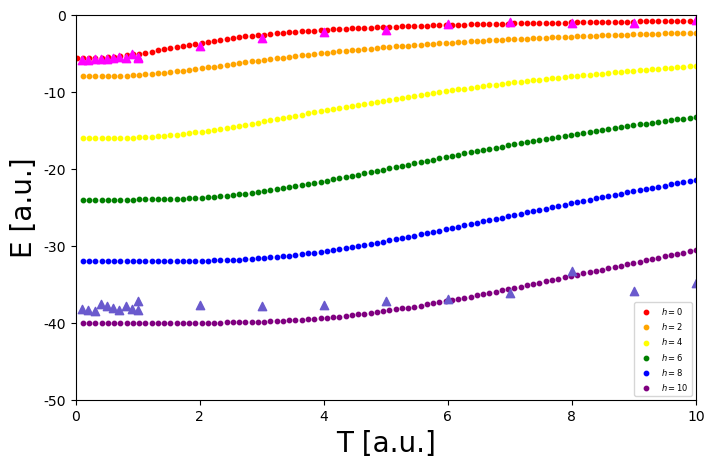

In [659]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

ax.scatter(T, NCE0, s=10, c='red', label=r'$h=0$')

ax.scatter(T, NCE2, s=10, c='orange', label=r'$h=2$')

ax.scatter(T, NCE4, s=10, c='yellow', label=r'$h=4$')

ax.scatter(T, NCE6, s=10, c='green', label=r'$h=6$')

ax.scatter(T, NCE8, s=10, c='blue', label=r'$h=8$')

ax.scatter(T, NCE10, s=10, c='purple', label=r'$h=10$')

ax.scatter(T1, E1, marker='^', color='magenta')
ax.scatter(T1, E10, marker='^', color='slateblue')

ax.legend(loc='lower right', fontsize=6)

ax.set_xlabel('T [a.u.]',fontsize=20)
ax.set_ylabel('E [a.u.]',fontsize=20)
ax.set_xlim(0, 10)
ax.set_ylim(-50, 0)

#### Energy Curve (minus)

(-50.0, 0.0)

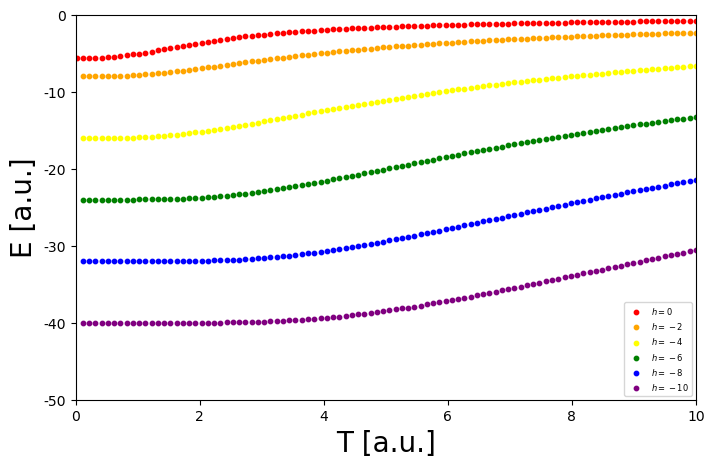

In [660]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

ax.scatter(T, NCE0, s=10, c='red', label=r'$h=0$')

ax.scatter(T, NCE2_, s=10, c='orange', label=r'$h=-2$')

ax.scatter(T, NCE4_, s=10, c='yellow', label=r'$h=-4$')

ax.scatter(T, NCE6_, s=10, c='green', label=r'$h=-6$')

ax.scatter(T, NCE8_, s=10, c='blue', label=r'$h=-8$')

ax.scatter(T, NCE10_, s=10, c='purple', label=r'$h=-10$')

ax.legend(loc='lower right', fontsize=6)

ax.set_xlabel('T [a.u.]',fontsize=20)
ax.set_ylabel('E [a.u.]',fontsize=20)
ax.set_xlim(0, 10)
ax.set_ylim(-50, 0)

#### Specific Heat Curve

(0.0, 2.0)

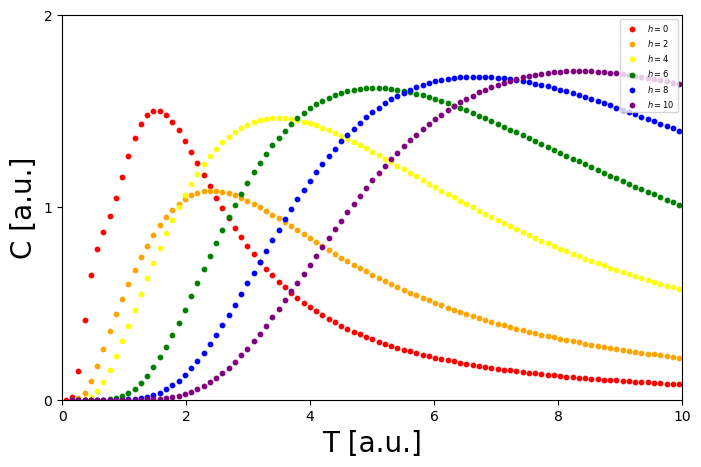

In [663]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

ax.scatter((np.array(T)[1:] + T[:-1]) / 2, np.divide(np.diff(np.array(NCE0)),np.diff(np.array(T))), s=10, c='red', label=r'$h=0$')

ax.scatter((np.array(T)[1:] + T[:-1]) / 2, np.divide(np.diff(np.array(NCE2)),np.diff(np.array(T))), s=10, c='orange', label=r'$h=2$')

ax.scatter((np.array(T)[1:] + T[:-1]) / 2, np.divide(np.diff(np.array(NCE4)),np.diff(np.array(T))), s=10, c='yellow', label=r'$h=4$')

ax.scatter((np.array(T)[1:] + T[:-1]) / 2, np.divide(np.diff(np.array(NCE6)),np.diff(np.array(T))), s=10, c='green', label=r'$h=6$')

ax.scatter((np.array(T)[1:] + T[:-1]) / 2, np.divide(np.diff(np.array(NCE8)),np.diff(np.array(T))), s=10, c='blue', label=r'$h=8$')

ax.scatter((np.array(T)[1:] + T[:-1]) / 2, np.divide(np.diff(np.array(NCE10)),np.diff(np.array(T))), s=10, c='purple', label=r'$h=10$')

ax.legend(loc='upper right', fontsize=6)

ax.set_xlabel('T [a.u.]',fontsize=20)
ax.set_ylabel('C [a.u.]',fontsize=20)
ax.set_xlim(0, 10)
ax.set_ylim(0, 2)

#### Whole Magnetization Curve

(0.0, 10.0)

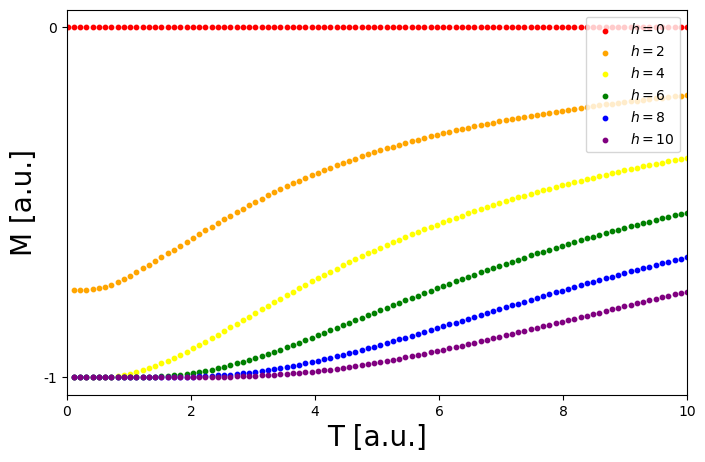

In [664]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

ax.scatter(T, NCM0, s=10, c='red', label=r'$h=0$')

ax.scatter(T, NCM2, s=10, c='orange', label=r'$h=2$')

ax.scatter(T, NCM4, s=10, c='yellow', label=r'$h=4$')

ax.scatter(T, NCM6, s=10, c='green', label=r'$h=6$')

ax.scatter(T, NCM8, s=10, c='blue', label=r'$h=8$')

ax.scatter(T, NCM10, s=10, c='purple', label=r'$h=10$')

ax.legend(loc='upper right', fontsize=10)

ax.set_xlabel('T [a.u.]',fontsize=20)
ax.set_ylabel('M [a.u.]',fontsize=20)
ax.set_xlim(0, 10)

#### Individual Magnetization Curve

Text(0, 0.5, 'M [a.u.]')

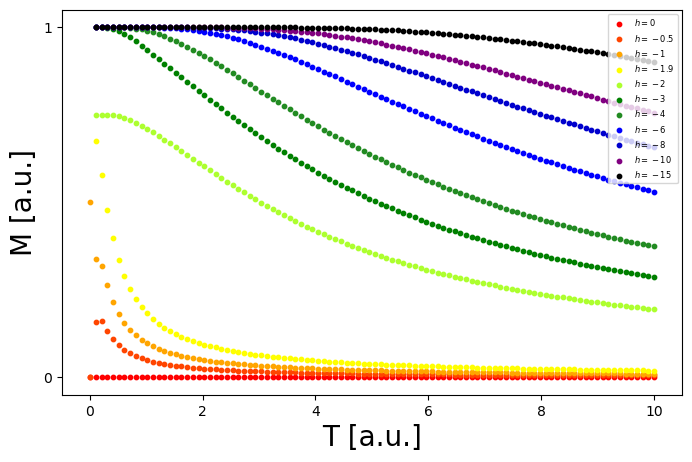

In [665]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

ax.scatter(T, NCM0, s=10, c='red', label=r'$h=0$')

ax.scatter(T, NCM_5_, s=10, c='orangered', label=r'$h=-0.5$')

ax.scatter(T, NCM1_, s=10, c='orange', label=r'$h=-1$')

ax.scatter(T, NCM1_9_, s=10, c='yellow', label=r'$h=-1.9$')

ax.scatter(T, NCM2_, s=10, c='greenyellow', label=r'$h=-2$')

ax.scatter(T, NCM3_, s=10, c='green', label=r'$h=-3$')

ax.scatter(T, NCM4_, s=10, c='forestgreen', label=r'$h=-4$')

ax.scatter(T, NCM6_, s=10, c='blue', label=r'$h=-6$')

ax.scatter(T, NCM8_, s=10, c='mediumblue', label=r'$h=-8$')

ax.scatter(T, NCM10_, s=10, c='purple', label=r'$h=-10$')

ax.scatter(T, NCM15_, s=10, c='black', label=r'$h=-15$')

ax.legend(loc='upper right', fontsize=6)

ax.set_xlabel('T [a.u.]',fontsize=20)
ax.set_ylabel('M [a.u.]',fontsize=20)

#### Order Parameter

(-1.0, 31.0)

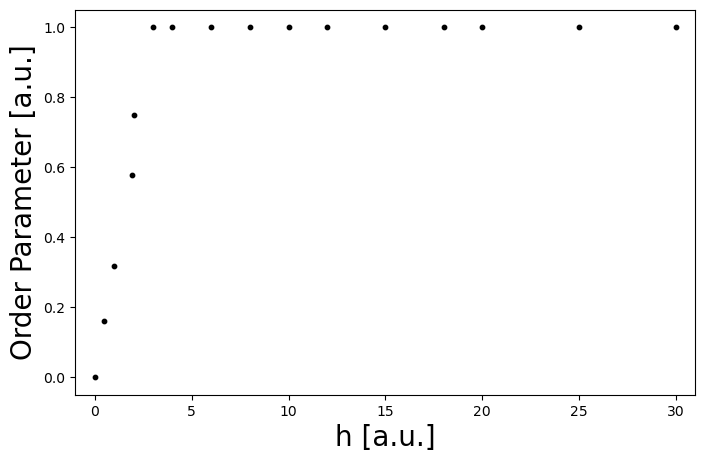

In [666]:
# T~0.2
OP=[]
OP.append(NCM0[97])
OP.append(NCM1_[97])
OP.append(NCM2_[97])
OP.append(NCM3_[97])
OP.append(NCM4_[97])
OP.append(NCM6_[97])
OP.append(NCM8_[97])
OP.append(NCM10_[97])
OP.append(NCM15_[97])
OP.append(NCM12_[97])
OP.append(NCM18_[97])
OP.append(NCM20_[97])
OP.append(NCM25_[97])
OP.append(NCM30_[97])
OP.append(NCM1_9_[97])
OP.append(NCM_5_[97])

EF=[]
EF.append(0)
EF.append(1)
EF.append(2)
EF.append(3)
EF.append(4)
EF.append(6)
EF.append(8)
EF.append(10)
EF.append(15)
EF.append(12)
EF.append(18)
EF.append(20)
EF.append(25)
EF.append(30)
EF.append(1.9)
EF.append(0.5)

fig, ax = plt.subplots(figsize=(8, 5))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

ax.scatter(EF, OP, s=10, c='black', label=r'Order Parameter')

ax.set_xlabel('h [a.u.]',fontsize=20)
ax.set_ylabel('Order Parameter [a.u.]',fontsize=20)
ax.set_xlim(-1, 31)

(-1.0, 31.0)

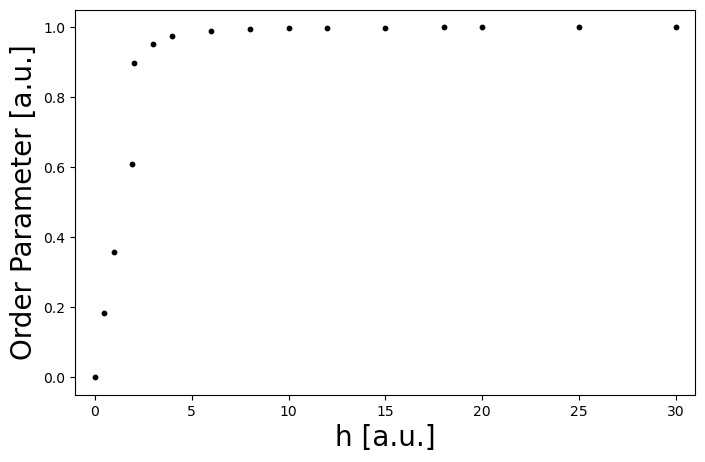

In [603]:
# T~0.5
OP=[]
OP.append(NCM0[94])
OP.append(NCM1_[94])
OP.append(NCM2_[94])
OP.append(NCM3_[94])
OP.append(NCM4_[94])
OP.append(NCM6_[94])
OP.append(NCM8_[94])
OP.append(NCM10_[94])
OP.append(NCM15_[94])
OP.append(NCM12_[94])
OP.append(NCM18_[94])
OP.append(NCM20_[94])
OP.append(NCM25_[94])
OP.append(NCM30_[94])
OP.append(NCM1_9_[94])
OP.append(NCM_5_[94])

EF=[]
EF.append(0)
EF.append(1)
EF.append(2)
EF.append(3)
EF.append(4)
EF.append(6)
EF.append(8)
EF.append(10)
EF.append(15)
EF.append(12)
EF.append(18)
EF.append(20)
EF.append(25)
EF.append(30)
EF.append(1.9)
EF.append(0.5)

fig, ax = plt.subplots(figsize=(8, 5))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

ax.scatter(EF, OP, s=10, c='black', label=r'Order Parameter')

ax.set_xlabel('h [a.u.]',fontsize=20)
ax.set_ylabel('Order Parameter [a.u.]',fontsize=20)
ax.set_xlim(-1, 31)

(-1.0, 31.0)

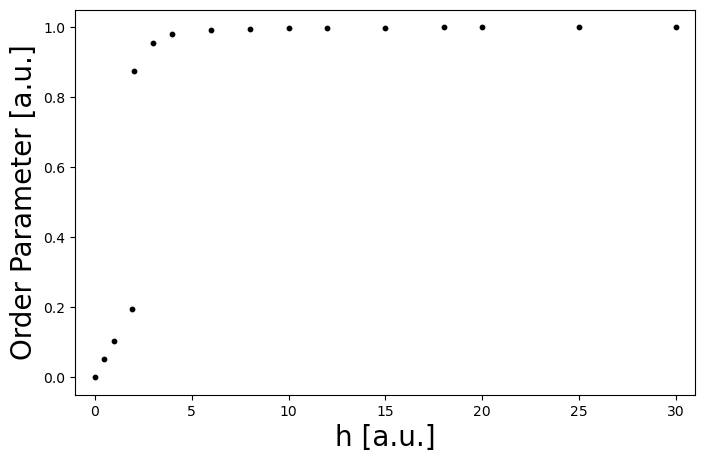

In [591]:
# T~2
OP=[]
OP.append(NCM0[80])
OP.append(NCM1_[80])
OP.append(NCM2_[80])
OP.append(NCM3_[80])
OP.append(NCM4_[80])
OP.append(NCM6_[80])
OP.append(NCM8_[80])
OP.append(NCM10_[80])
OP.append(NCM15_[80])
OP.append(NCM12_[80])
OP.append(NCM18_[80])
OP.append(NCM20_[80])
OP.append(NCM25_[80])
OP.append(NCM30_[80])
OP.append(NCM1_9_[80])
OP.append(NCM_5_[80])

EF=[]
EF.append(0)
EF.append(1)
EF.append(2)
EF.append(3)
EF.append(4)
EF.append(6)
EF.append(8)
EF.append(10)
EF.append(15)
EF.append(12)
EF.append(18)
EF.append(20)
EF.append(25)
EF.append(30)
EF.append(1.9)
EF.append(0.5)

fig, ax = plt.subplots(figsize=(8, 5))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

ax.scatter(EF, OP, s=10, c='black', label=r'Order Parameter')

ax.set_xlabel('h [a.u.]',fontsize=20)
ax.set_ylabel('Order Parameter [a.u.]',fontsize=20)
ax.set_xlim(-1, 31)

(-1.0, 31.0)

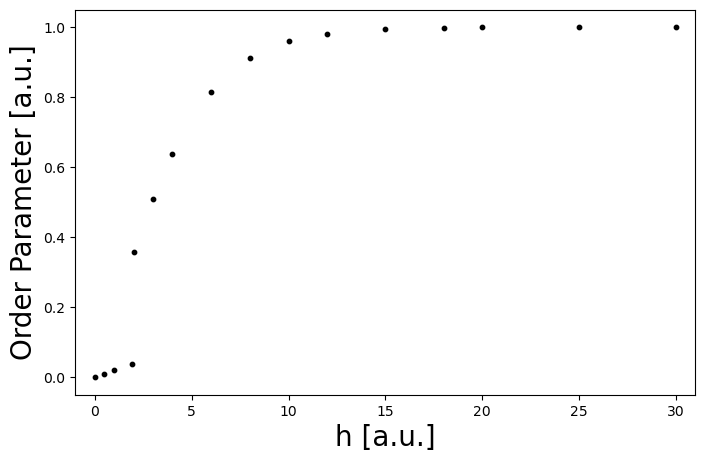

In [667]:
# T~5
OP=[]
OP.append(NCM0[50])
OP.append(NCM1_[50])
OP.append(NCM2_[50])
OP.append(NCM3_[50])
OP.append(NCM4_[50])
OP.append(NCM6_[50])
OP.append(NCM8_[50])
OP.append(NCM10_[50])
OP.append(NCM15_[50])
OP.append(NCM12_[50])
OP.append(NCM18_[50])
OP.append(NCM20_[50])
OP.append(NCM25_[50])
OP.append(NCM30_[50])
OP.append(NCM1_9_[50])
OP.append(NCM_5_[50])

EF=[]
EF.append(0)
EF.append(1)
EF.append(2)
EF.append(3)
EF.append(4)
EF.append(6)
EF.append(8)
EF.append(10)
EF.append(15)
EF.append(12)
EF.append(18)
EF.append(20)
EF.append(25)
EF.append(30)
EF.append(1.9)
EF.append(0.5)

fig, ax = plt.subplots(figsize=(8, 5))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

ax.scatter(EF, OP, s=10, c='black', label=r'Order Parameter')

ax.set_xlabel('h [a.u.]',fontsize=20)
ax.set_ylabel('Order Parameter [a.u.]',fontsize=20)
ax.set_xlim(-1, 31)